Automatically analysis all data-files in a dataset
=======

Import the required bits.

In [9]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import mindaffectBCI.decoder.offline.datasets as datasets
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised, print_decoding_curve, plot_decoding_curve
from mindaffectBCI.decoder.analyse_datasets import decoding_curve_GridSearchCV, datasets_decoding_curve_GridSearchCV, average_results_per_config, plot_decoding_curves
from mindaffectBCI.decoder.preprocess_transforms import make_preprocess_pipeline, ClassAveragePlotter

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Analyse all datafiles in a single dataset with given analysis settings
-----


### Tell the system the directory where the datasets directory is located

In [2]:
# tell the system where the data is stored..
#datasets.add_dataroot('')
datasets.set_dataroot('D://')
datasets.get_dataroot()

'D://'

## set the dataset you want and get the list of files in it.
* `dataset` is parent directory name, relative to dataroot, to search for datasets
* `label` is human readable label for this dataset+analysis for plots etc.

In [ ]:
# Lowlands
dataset='lowlands'
dataset_args=dict()
label='lowlands'

In [3]:
# plos_one
dataset='plos_one'
dataset_args=dict()
label='plos_one'

In [ ]:
# 8-subj, 2-sessions
dataset='mindaffectBCI'
dataset_args=dict(exptdir="cVEP_bci",regexp='noisetag_bci.*',exregexp='vid')

## get the list of datasets and the loader object

In [4]:
loader,filenames,_ = datasets.get_dataset(dataset, **dataset_args)
cp = os.path.commonprefix(filenames)
labels = [ p[len(cp):] for p in filenames ]
print("{} has {} files\n{}".format(dataset,len(filenames),"\n".join(labels)))

plos_one has 12 files
01\traindata.mat
10\traindata.mat
11\traindata.mat
12\traindata.mat
02\traindata.mat
3\traindata.mat
4\traindata.mat
5\traindata.mat
6\traindata.mat
7\traindata.mat
8\traindata.mat
9\traindata.mat


## Fit model to each of the datasets

## Specify the analysis pipeline you want to use.
The pipeline is given as a list of 'stages' which will be processed in turn by calling the appropriate class's `fit` and `modify` methods.   See `decoder/preprocess_transforms.py` for a list of available transforms.

Here we use:
  * `MetaInfoAdder` : to attach important meta-info, specifically the data samplerate and the list of channel names. 
  * `ButterFilterAndResampler` : To use a 'butterworth' IIR filter to first spectrally filter the data and then downsample it to a new sample rate
  * `MultiCCA` : This is the Cannonical Correlation Analysis based Sequence2Sequence classifier we use for the analysis.  For more information on the available Sequence2Sequence classifiers available see `decoder/model_fitting.py`


In [6]:
# Single Cell version: all fixed!

# default pipeline
fs_out = 180
loader_args={'fs_out':fs_out,'filterband':((0,1),(45,65),(95,105),(145,155),(195,205))}#,'sample2timestamp':'lower_bound_tracker'}#'robust_timestamp_regression'}# 
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':-1}}],
    ['ButterFilterAndResampler',{'filterband':[(3,25,'bandpass')], 'fs_out':fs_out}],
    #['TargetEncoder',{'evtlabs':('re','fe')}],
    ['MultiCCACV:clsfr',{'tau_ms':450, 'offset_ms':0,'evtlabs':('re','fe'), 'temporal_basis':'fourier2,8'}], #
    #['BwdLinearRegressionCV:clsfr',{"tau_ms":450, "inner_cv_params":{"reg":(1e-4, 1e-3, .01, .1, .5, 1-.1, 1-.01)}}]
    #['MultiCCA:clsfr',{'tau_ms':450, 'offset_ms':0}]
]
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

## Test: run a single dataset with this pipeline
By:
1. Loading the data
2. Visualizing the data, via. and ERP plot
2. Making the analysis pipeline
3. Fit the pipeline to the data
4. Assessing the fitted model quality

Note: you can access the created or fitted data transformation 'stages' through the `stages` property of the created pipeline.

In [7]:
# 1. Load the data, extract meta-info
X_TSd, Y_TSy, coords = loader(filenames[0],**loader_args)
fs=coords[1]['fs']
ch_names=coords[2]['coords']


[27216]


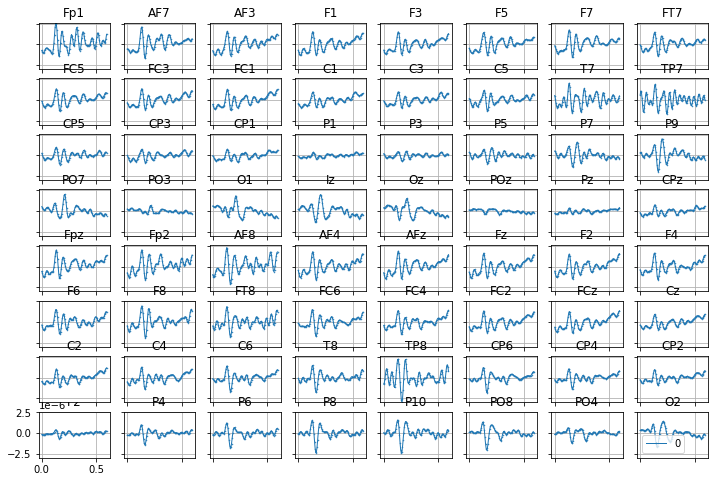

EventRelatedPotentialPlotter(fig=<Figure size 864x576 with 64 Axes>, tau_ms=600)

In [11]:
# plot the average response when the stimulus is high, to give idea of the signal2noise
ClassAveragePlotter(tau_ms=600).fit(X_TSd, Y_TSy, fs=fs, ch_names=ch_names)

PreprocessPipeline(stages=[('metainfoadder',
                            MetaInfoAdder(info={'ch_names': ['Fp1', 'AF7',
                                                             'AF3', 'F1', 'F3',
                                                             'F5', 'F7', 'FT7',
                                                             'FC5', 'FC3',
                                                             'FC1', 'C1', 'C3',
                                                             'C5', 'T7', 'TP7',
                                                             'CP5', 'CP3',
                                                             'CP1', 'P1', 'P3',
                                                             'P5', 'P7', 'P9',
                                                             'PO7', 'PO3', 'O1',
                                                             'Iz', 'Oz', 'POz', ...],
                                                'fs': 180})),
                      

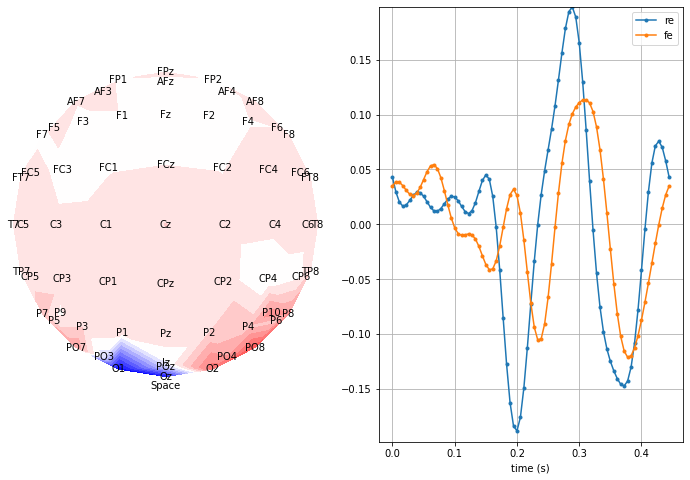

In [12]:
# 2. Make the analysis pipeline -- after updating the metainfo adder to reflect the data properties
pipeline[0][1]['info'] = {'fs':fs,'ch_names':ch_names}
ppp = make_preprocess_pipeline(pipeline)
# 3. Fit the pipeline to the data
ppp.fit(X_TSd,Y_TSy)
# 4. plot the fitted classifier model, i.e. last stage
ppp.stages[-1][1].plot_model(fs=fs,ch_names=ch_names)


     -> best={},1 = 0.690
 Retraining on all data with: rank=1 reg=(1e-08, 1e-08)
Int Lens:..............................

            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.61  0.31  0.22  0.25  0.17  0.11  0.14  0.14   AUDC 30.2
         Perr(est)  0.45  0.26  0.22  0.15  0.10  0.11  0.10  0.09   PSAE 43.4
           StopErr  0.61  0.44  0.31  0.19  0.19  0.19  0.19  0.19   AUSC 32.5
     StopThresh(P)  0.21  0.12  0.08  0.08  0.08  0.08  0.08  0.08   SSAE 148.3



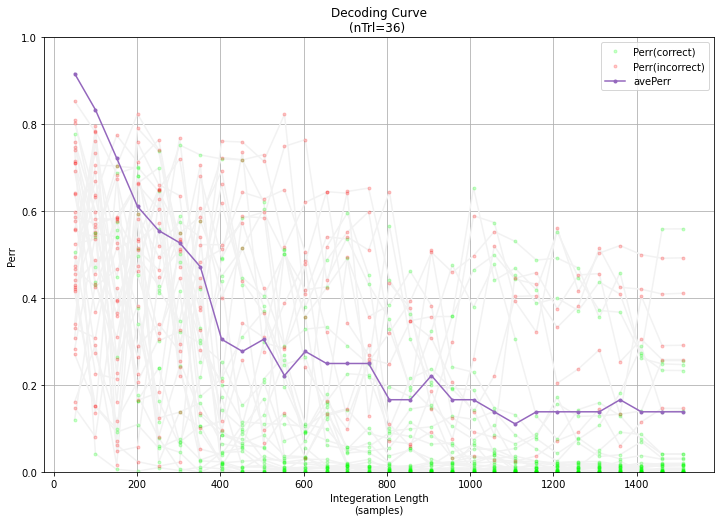

In [13]:
# 4. Assess the fitted model performance.   
#    As we want a cv'd estimate of the classifier performance we do this in 3 stages,
#    a) we apply the fitted model before the classifier to the data
Xpp_TSd, Ypp_TSye = ppp.modify(X_TSd,Y_TSy,until_stage=-1)
#    b) then we cv apply the classifer to get a cv'd classifier prediction
res = ppp.stages[-1][1].cv_fit(Xpp_TSd, Ypp_TSye)
#    c) then we assess the performance of these cv'd predictions
plot_decoding_curve( *decodingCurveSupervised(res['estimator']))

## Now do the same for all data-sets together and collate the results to a final performance

Running with 3 parallel tasks, one-per-filename
Submitting {} jobs:............12 jobs submitted in    0s. Waiting results.

8% 1 / 12 collected in  7.7s  est 91.9s total 84.3s remaining
33% 4 / 12 collected in 13.0s  est 39.1s total 26.1s remaining
58% 7 / 12 collected in 17.1s  est 29.4s total 12.2s remaining
83% 10 / 12 collected in 20.7s  est 24.8s total  4.1s remaining
Ave-DC
            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.69  0.42  0.33  0.27  0.25  0.20  0.20  0.18   AUDC 35.5
         Perr(est)  0.50  0.34  0.29  0.23  0.19  0.17  0.14  0.14   PSAE 27.7
           StopErr  0.95  0.95  0.75  0.56  0.48  0.45  0.43  0.43   AUSC 64.8
     StopThresh(P)  0.72  0.72  0.51  0.40  0.36  0.37  0.37  0.37   SSAE 29.8



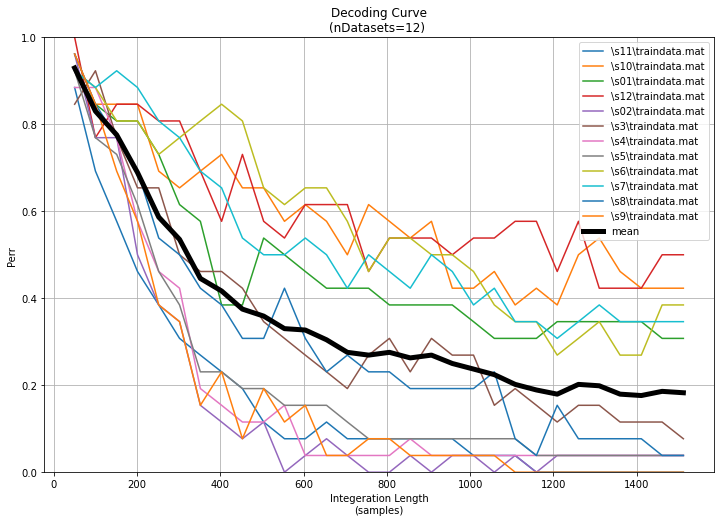

In [36]:
# run the model fit
# first make the base pipeline to run
ppp = make_preprocess_pipeline(pipeline)

# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=3, 
                                           cv_clsfr_only=False)


print("Ave-DC")
print(print_decoding_curve(*(average_results_per_config(res)['decoding_curve'][0])))

plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['filename'])
plt.show(block=True)

# Run different parameter settings and compare final performance
Now let's see the effect of varying some of the 'hyperparameters' of the pipeline

Specify the general default analysis parameters

specify the `tuned_parameters` grid to evaluate.

**N.B. each field should contain a list of valid parameter settings**

In [20]:
tuned_parameters=dict()
#tuned_parameters['clsfr__evtlabs']=[('re','fe'),('re','fe','anyfe')]
tuned_parameters['clsfr__tau_ms']=[350]
tuned_parameters['clsfr__offset_ms']=[0,100]
#tuned_parameters['clsfr__temporal_basis']=['none','fourier1,10','fourier2,10','fourier2,15']

Now run the cross dataset analysis.    **This may take some time**   To speed things up a bit we use the concurrent version which will run up to num_cpu_threads datafiles in parallel.

At the end you will get a textual summary of the results, and the detailed results are returned.

In [21]:
ppp = make_preprocess_pipeline(pipeline)
# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=4, 
                                           cv_clsfr_only=False, tuned_parameters=tuned_parameters)

Running with 4 parallel tasks, one-per-filename
Submitting {} jobs:............12 jobs submitted in    0s. Waiting results.

8% 1 / 12 collected in 13.7s  est 164.9s total 151.1s remaining
33% 4 / 12 collected in 109.1s  est 327.2s total 218.1s remaining
66% 8 / 12 collected in 118.7s  est 178.0s total 59.3s remaining
100% 12 / 12 collected in 123.9s  est 123.9s total  0.0s remaining


### Visualize the reslts

Ave-DC


{'clsfr__offset_ms': 0, 'clsfr__tau_ms': 350}

            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.69  0.43  0.40  0.35  0.29  0.28  0.25  0.23   AUDC 39.9
         Perr(est)  0.51  0.39  0.31  0.26  0.22  0.20  0.19  0.18   PSAE 31.7
           StopErr  0.95  0.95  0.80  0.59  0.49  0.48  0.46  0.46   AUSC 66.4
     StopThresh(P)  0.70  0.70  0.53  0.40  0.38  0.39  0.40  0.40   SSAE 31.2



{'clsfr__offset_ms': 100, 'clsfr__tau_ms': 350}

            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.94  0.91  0.92  0.89  0.88  0.89  0.88  0.87   AUDC 89.6
         Perr(est)  0.55  0.48  0.46  0.44  0.42  0.40  0.41  0.39   PSAE 101.8
           StopErr  0.98  0.98  0.96  0.94  0.92  0.91  0.90  0.91   AUSC 94.1
     StopThresh(P)  0.74  0.74  0.56  0.46  0.44  0.47  0.52  0.52   SSAE 71.8



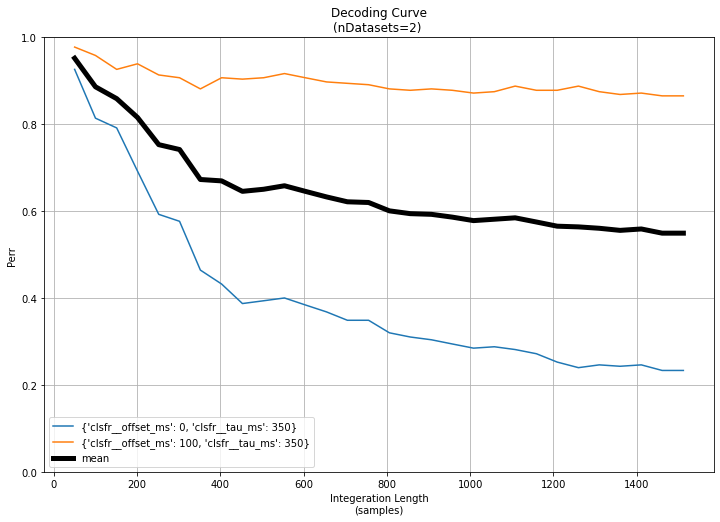

In [22]:
# average the results over data-files for each pipeline configuration
averes = average_results_per_config(res)

print("Ave-DC")
# report the per-config summary
for dc,conf in zip(averes['decoding_curve'],averes['config']):
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))

plot_decoding_curves(averes['decoding_curve'],labels=res['config'])
plt.show(block=True)